In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import joblib

In [7]:
customer_df = pd.read_csv("customer_clean.csv")
payment_df = pd.read_csv("payment_clean.csv")

df = customer_df.merge(payment_df, on="id", how="left")
df.fillna(df.median(numeric_only=True), inplace=True)

In [8]:
# Feature: debt_ratio = new_balance / credit_limit
df["debt_ratio"] = df["new_balance"] / (df["credit_limit"] + 1e-5)

# Feature: is_over_limit
df["is_over_limit"] = (df["new_balance"] > df["credit_limit"]).astype(int)

# Feature: mean overdue
df["mean_ovd"] = df[["OVD_t1", "OVD_t2", "OVD_t3"]].mean(axis=1)

In [9]:
drop_cols = ["id", "label", "update_date", "report_date"]
X = df.drop(columns=drop_cols, errors='ignore')
y = df["label"]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

pipeline = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42)),
    ("xgb", xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

In [11]:
param_grid = {
    "xgb__n_estimators": [100, 200],
    "xgb__max_depth": [3, 5],
    "xgb__learning_rate": [0.05, 0.1],
    "xgb__subsample": [0.8, 1.0]
}

grid = GridSearchCV(pipeline, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)

with mlflow.start_run(run_name="xgboost_pipeline_gridsearch"):

    mlflow.log_params(grid.best_params_)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    mlflow.log_metric("roc_auc", roc_auc)

    mlflow.sklearn.log_model(grid.best_estimator_, "model")

    print(f"Run saved in MLflow with ROC-AUC: {roc_auc:.4f}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Users/valentinabordei/Desktop/airflow_project/airflow_venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/valentinabordei/Desktop/airflow_project/airflow_venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/valentinabordei/Desktop/airflow_project/airflow_venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:02:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/valentinabordei/Desktop/airflow_project/airflow_venv/lib/python3.10/site-packages/xgboost/training.

Best params: {'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}


/Users/valentinabordei/Desktop/airflow_project/airflow_venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/valentinabordei/Desktop/airflow_project/airflow_venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/valentinabordei/Desktop/airflow_project/airflow_venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:02:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


MlflowException: Could not find experiment with ID 0

ROC-AUC: 0.5483870967741935
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.75      0.77       127
           1       0.18      0.23      0.20        31

    accuracy                           0.65       158
   macro avg       0.49      0.49      0.49       158
weighted avg       0.68      0.65      0.66       158



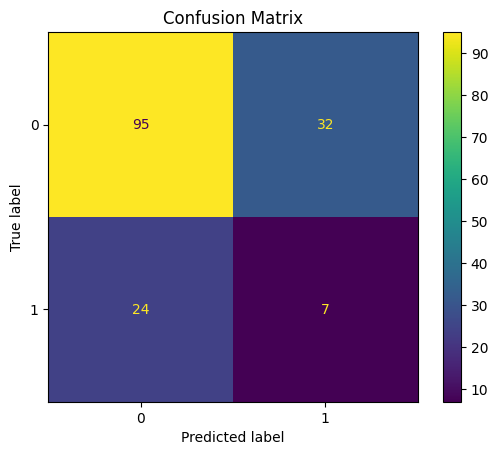

In [12]:
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
plt.title("Confusion Matrix")
plt.show()

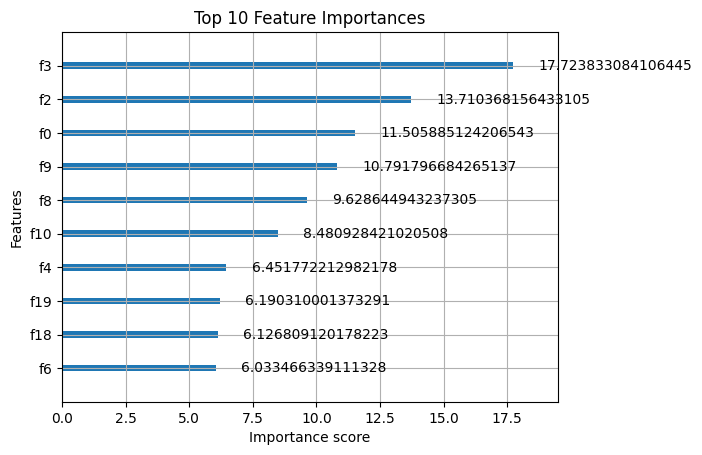

In [13]:
model_final = grid.best_estimator_.named_steps["xgb"]
xgb.plot_importance(model_final, max_num_features=10, importance_type="gain")
plt.title("Top 10 Feature Importances")
plt.show()

In [14]:
joblib.dump(grid.best_estimator_, "xgb_model.pkl")
print("Model salvat în xgb_model.pkl")

Model salvat în xgb_model.pkl
[CV] END xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.0s
[CV] END xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.0s
[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.1s
[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.0s
[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_estimators=200, xgb__subsample=1.0; total time=   0.1s
[CV] END xgb__learning_rate=0.1, xgb__max_depth=5, xgb__n_estimators=100, xgb__subsample=1.0; total time=   0.0s
[CV] END xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=100, xgb__subsample=0.8; total time=   0.0s
[CV] END xgb__learning_rate=0.05, xgb__max_depth=3, xgb__n_estimators=200, xgb__subsample=0.8; total time=   0.0s
[CV] END xgb__learning_rate=0.05, xgb__max_depth=5, xgb__n_

In [16]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("file:///Users/valentinabordei/Desktop/MLOPS/mlruns")
mlflow.set_experiment("xgb_experiment")

with mlflow.start_run():
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("roc_auc", roc_auc_score(y_test, y_proba))
    mlflow.sklearn.log_model(grid.best_estimator_, "xgb_model")

2025/07/27 18:11:08 INFO mlflow.tracking.fluent: Experiment with name 'xgb_experiment' does not exist. Creating a new experiment.
2025/07/27 18:11:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/27 18:11:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
